In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [2]:
df = yf.download('TSLA', period='1y', interval='1h')[['Open', 'High', 'Low', 'Close']]

df

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close
Ticker,TSLA,TSLA,TSLA,TSLA
Datetime,,,,
2024-04-01 13:30:00+00:00,176.160004,176.389999,171.600006,171.727997
2024-04-01 14:30:00+00:00,171.740005,172.189896,170.210007,172.104996
2024-04-01 15:30:00+00:00,172.089996,172.429993,170.889999,172.279999
2024-04-01 16:30:00+00:00,172.288193,173.277100,171.740005,171.889999
2024-04-01 17:30:00+00:00,171.860001,173.104996,171.750000,172.940002
...,...,...,...,...
2025-03-31 15:30:00+00:00,250.902496,255.250000,250.179993,254.839996
2025-03-31 16:30:00+00:00,254.839996,256.899994,253.660004,254.250000


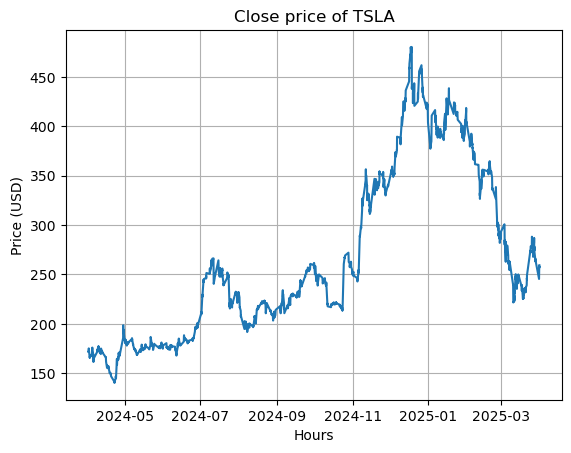

In [3]:
import matplotlib.pyplot as plt

plt.plot(df['Close'])
plt.title("Close price of TSLA")
plt.grid(True)
plt.xlabel("Hours")
plt.ylabel("Price (USD)")
plt.show()


In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

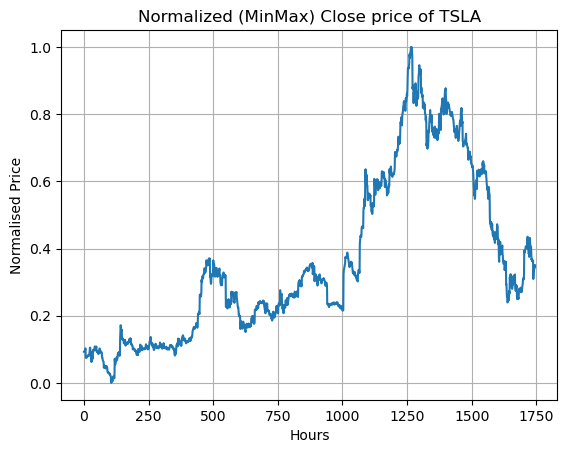

In [5]:
plt.plot(scaled_data)
plt.title("Normalized (MinMax) Close price of TSLA")
plt.grid(True)
plt.xlabel("Hours")
plt.ylabel("Normalised Price")
plt.show()

In [6]:
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [7]:
# Create sequences for training with a look-back of 60 time steps (for 60 hours)
look_back = 60
X, y = create_sequences(scaled_data, look_back)

In [8]:
# Reshape the data for RNN input: [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Convert data to PyTorch tensors
X = torch.Tensor(X)
y = torch.Tensor(y)

In [9]:
# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [10]:
# Define the vanilla RNN model in PyTorch
class VanillaRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super(VanillaRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Take the output from the last time step
        return out

In [11]:
# Initialize the model, loss function, and optimizer
model = VanillaRNN(input_size=1, hidden_size=50, output_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
# Train the model
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train.view(-1, 1))
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 1 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


Epoch [1/1000], Loss: 0.1306
Epoch [2/1000], Loss: 0.1050
Epoch [3/1000], Loss: 0.0838
Epoch [4/1000], Loss: 0.0672
Epoch [5/1000], Loss: 0.0556
Epoch [6/1000], Loss: 0.0494
Epoch [7/1000], Loss: 0.0484
Epoch [8/1000], Loss: 0.0512
Epoch [9/1000], Loss: 0.0545
Epoch [10/1000], Loss: 0.0556
Epoch [11/1000], Loss: 0.0540
Epoch [12/1000], Loss: 0.0505
Epoch [13/1000], Loss: 0.0464
Epoch [14/1000], Loss: 0.0427
Epoch [15/1000], Loss: 0.0399
Epoch [16/1000], Loss: 0.0382
Epoch [17/1000], Loss: 0.0373
Epoch [18/1000], Loss: 0.0369
Epoch [19/1000], Loss: 0.0367
Epoch [20/1000], Loss: 0.0363
Epoch [21/1000], Loss: 0.0355
Epoch [22/1000], Loss: 0.0341
Epoch [23/1000], Loss: 0.0323
Epoch [24/1000], Loss: 0.0301
Epoch [25/1000], Loss: 0.0277
Epoch [26/1000], Loss: 0.0254
Epoch [27/1000], Loss: 0.0234
Epoch [28/1000], Loss: 0.0217
Epoch [29/1000], Loss: 0.0204
Epoch [30/1000], Loss: 0.0190
Epoch [31/1000], Loss: 0.0173
Epoch [32/1000], Loss: 0.0149
Epoch [33/1000], Loss: 0.0121
Epoch [34/1000], Lo

[[0.8176319 ]
 [0.8256237 ]
 [0.8315497 ]
 [0.833283  ]
 [0.8308024 ]
 [0.8273032 ]
 [0.82308733]
 [0.8186024 ]
 [0.8140671 ]
 [0.809687  ]
 [0.80606633]
 [0.8019865 ]
 [0.79934984]
 [0.79792583]
 [0.7965259 ]
 [0.7969211 ]
 [0.80006486]
 [0.8032051 ]
 [0.8033052 ]
 [0.8005219 ]
 [0.79550683]
 [0.7897364 ]
 [0.78529984]
 [0.7801256 ]
 [0.77292925]
 [0.76510894]
 [0.75682086]
 [0.7518763 ]
 [0.74994904]
 [0.7508674 ]
 [0.7510973 ]
 [0.74576503]
 [0.74194074]
 [0.74255437]
 [0.74626845]
 [0.7539969 ]
 [0.7604851 ]
 [0.7587449 ]
 [0.75028807]
 [0.74155015]
 [0.7358583 ]
 [0.7302659 ]
 [0.7293772 ]
 [0.73130757]
 [0.7347953 ]
 [0.74295837]
 [0.75298685]
 [0.76404387]
 [0.77343446]
 [0.7796969 ]
 [0.77932924]
 [0.78378564]
 [0.7946621 ]
 [0.80599374]
 [0.813576  ]
 [0.8104677 ]
 [0.7972426 ]
 [0.78376   ]
 [0.762157  ]
 [0.7372926 ]
 [0.71796817]
 [0.7062359 ]
 [0.7050485 ]
 [0.7105437 ]
 [0.7167036 ]
 [0.7207865 ]
 [0.7217034 ]
 [0.7199606 ]
 [0.7202091 ]
 [0.72339064]
 [0.72845703]
 [0.73

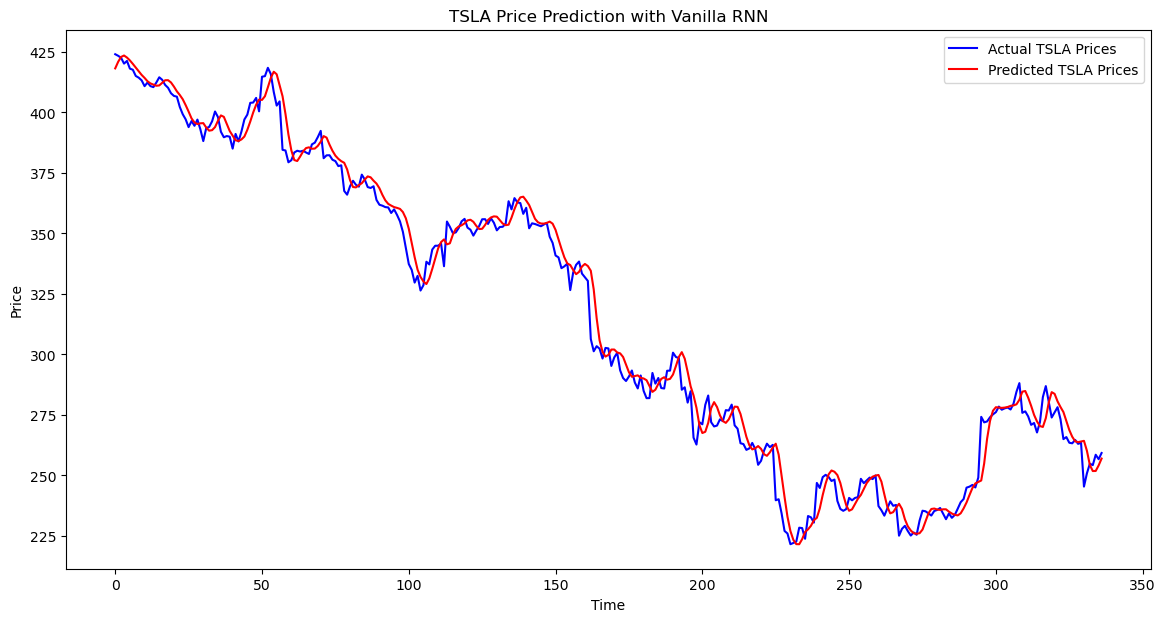

In [13]:
# Make predictions
model.eval()
predictions = model(X_test).detach().numpy()

print(predictions)

# Inverse scale the predictions and the actual values to get actual prices
predicted_prices = scaler.inverse_transform(predictions)
actual_prices = scaler.inverse_transform(y_test.view(-1, 1))

# Plot the results
plt.figure(figsize=(14, 7))

# Plot actual vs predicted prices
plt.plot(actual_prices, color='blue', label='Actual TSLA Prices')
plt.plot(predicted_prices, color='red', label='Predicted TSLA Prices')
plt.title('TSLA Price Prediction with Vanilla RNN')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
